# Simulation 1 - Countsketch attack

 Final version.

This code simulate the attack on CountSketch with median estimator. This simulation tracks 3 keys deviation w.r.t an aggregated attack vector.

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import math

class Countsketch_median_attack:
    def __init__(self, num_of_rounds=100, nof_repititions = 10, nof_sim_keys=11, tail_size=1000, b=30, l=100, seed=None):
        self.num_of_rounds   = num_of_rounds
        self.nof_repititions = nof_repititions
        self.nof_sim_keys    = nof_sim_keys
        self.tail_size       = tail_size
        self.l               = l
        self.b               = b
        self.seed            = seed
        self.rng             = default_rng(seed)
        self.results         = np.zeros((self.num_of_rounds, self.nof_sim_keys), dtype=float)

    def __repr__(self):
        return "test parameters:\n number of rounds = {0}; number of repititions = {6}\n num of keys simulated = {1};\n attack tail size = {2};\n l = {3};\n b = {4}; seed = {5};" \
            .format(self.num_of_rounds, self.nof_sim_keys, self.tail_size, self.l, self.b, self.seed, self.nof_repititions)

    def draw_sketch(self):
        self.sim_keys_hash = self.rng.choice(self.b, size=(self.l, self.nof_sim_keys)) 
        self.sim_keys_sign = self.rng.choice(2     , size=(self.l, self.nof_sim_keys)) * 2 - 1
        
    def generate_v(self, mk_factor=10, lk_factor=20):
        sd = math.sqrt(self.tail_size / self.b)
        lk_weight = int(sd * lk_factor)
        mk_weight = int(sd * mk_factor)
        v = np.ones(self.nof_sim_keys, dtype=int)
        v[0: 2] = mk_weight
        v[2:  ] = lk_weight
        return v
    
    def encode_v(self, v):
        counters_v = np.zeros((self.l, self.b), dtype=int)
        for line in range(self.l):
            for key in range(self.nof_sim_keys):
                counters_v[line, self.sim_keys_hash[line, key]] += v[key] * self.sim_keys_sign[line, key]
        return counters_v
    
    def decode_v(self, counters):
        weak_estimates = np.zeros((self.l, self.nof_sim_keys), dtype=int)
        for line in range(self.l):
            for key in range(self.nof_sim_keys):
                weak_estimates[line, key] = counters[line, self.sim_keys_hash[line, key]] * self.sim_keys_sign[line, key]
        # for even length axis: returns average of the two medians
        estimates = np.median(weak_estimates, axis=0)
        return estimates
        
    def check_parameters(self, nof_checks = 100):
        # pass if all sketch draws return exact estimates for v
        v = self.generate_v()
        results = np.zeros(nof_checks, dtype=int)
        for i in range(nof_checks):
            self.draw_sketch()
            estimates_v = self.decode_v(self.encode_v(v))
            results[i] = np.absolute(estimates_v - v).sum()
        print("parameters OK")
        return results.sum() == 0
    
    def gencode_z(self):
        counters_z = np.zeros((self.l, self.b), dtype=int)
        for line in range(self.l):
            tail_hash = self.rng.choice(self.b, size=self.tail_size)
            tail_sign = self.rng.choice(2     , size=self.tail_size) * 2 - 1
            for key in range(self.tail_size):
                counters_z[line, tail_hash[key]] += tail_sign[key]
        return counters_z

    def simulate_median_attack(self, files_pref = "sim_1", new_seed=None):
        if new_seed is not None:
            self.seed = new_seed
            self.rng = default_rng(new_seed)
        self.results = np.zeros((self.num_of_rounds, 3, self.nof_repititions), dtype=float)
        # here we add looping over 10 repititions
        for rep in range(self.nof_repititions):
            self.draw_sketch()
            nof_collected = 0
            v = self.generate_v()
            counters_a = np.zeros((self.l, self.b), dtype=int)
            for r in range(self.num_of_rounds):
                # query
                counters_v = self.encode_v(v)
                counters_z = self.gencode_z()
                estimates_q = self.decode_v(counters_v + counters_z)
                key_0_reported = estimates_q[0] >= sorted(estimates_q)[1]
                key_1_reported = estimates_q[1] >= sorted(estimates_q)[1]
                # collecting desicion
                if key_0_reported and (not key_1_reported):
                    counters_a = counters_a + counters_z
                    nof_collected += 1
                if key_1_reported and (not key_0_reported):
                    counters_a = counters_a - counters_z
                    nof_collected += 1
                # saving the keys signal
                factor = 1
                if nof_collected > 0:
                    factor = math.sqrt(nof_collected * self.tail_size / self.b)
                estimates_a = self.decode_v(counters_a)
                self.results[r, :, rep] = estimates_a[0:3] / factor
            # here we ouput a file
            print("saving file for rep = {0}".format(rep))
            file_name = "./results/{0}_rep_{1}.csv".format(files_pref, rep)
            np.savetxt(file_name, self.results[:,:, rep], delimiter=',')
        return self.results



In [67]:
test_1 = Countsketch_median_attack()
print(test_1)

if (test_1.check_parameters()):
    test_1.simulate_median_attack(files_pref = "sim_1_run")

test parameters:
 number of rounds = 5; number of repititions = 10
 num of keys simulated = 11;
 attack tail size = 1000;
 l = 100;
 b = 30; seed = None;
parameters OK
saving file for rep = 0
saving file for rep = 1
saving file for rep = 2
saving file for rep = 3
saving file for rep = 4
saving file for rep = 5
saving file for rep = 6
saving file for rep = 7
saving file for rep = 8
saving file for rep = 9


In [69]:
loaded_np_array = np.loadtxt('./results/sim_1_skeleton_rep_0.csv', delimiter=',')
print(loaded_np_array.shape)
print(loaded_np_array.shape[0])
print(loaded_np_array)

(5, 3)
5
[[ 0.08660254  0.          0.08660254]
 [ 0.12247449  0.         -0.06123724]
 [ 0.15        0.05       -0.1       ]
 [ 0.08660254  0.         -0.08660254]
 [ 0.15491933  0.03872983 -0.03872983]]


[ 0.90217019 -0.45447671  0.06104911]
(200, 3)


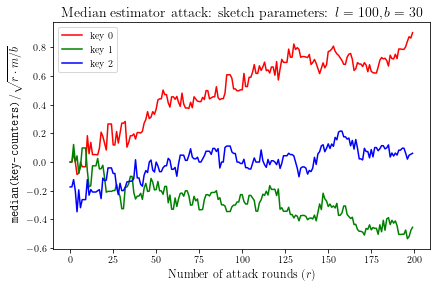

In [518]:
print(test.results[-1])
print(test.results.shape)
test.plot_results()

(500, 3)


In [54]:
test = Countsketch_median_attack(num_of_rounds=100, nof_sim_keys=11, tail_size=1000, b=30, l=100)

test.draw_sketch()
v = test.generate_v()
#print(v)

counters_v = test.encode_v(v)
#print(counters_v)
counters_z = test.gencode_z()
#print(counters_z)
estimates_q = test.decode_v(counters_v + counters_z)
print(estimates_q)
print(sorted(estimates_q))
key_0_reported = estimates_q[0] >= sorted(estimates_q)[1]
key_1_reported = estimates_q[1] >= sorted(estimates_q)[1]
print(key_0_reported)
print(key_1_reported)

if key_0_reported and (not key_1_reported): print(0)
if key_1_reported and (not key_0_reported): print(1)

[ 55.5  56.  116.  114.  118.  114.  114.  116.  115.  116.  114. ]
[55.5, 56.0, 114.0, 114.0, 114.0, 114.0, 115.0, 116.0, 116.0, 116.0, 118.0]
False
True
1


In [16]:
test = Countsketch_median_attack(num_of_rounds=100, nof_sim_keys=11, tail_size=1000, b=30, l=5)
print(test.gencode_z())

[[  1   0 -10  -1   8  -1  -4  -4   4   6   1  -7   0  -6   3   2  -9  -5
    1   8   2  -4  -3   3   0   3 -11  -1  -3   9]
 [  2   1   5  -7  -3   8   7   1  -9  -3   9   3   1   0   1   3  -1  -5
    5   1   1  -5  -6   3  -8  -5   2  -2  -9  -2]
 [  1  -5  -6   5  -3  -3   9   1   2  -6   3  -6   5  -1  -2   2   8   0
   -2  -2  -2  -4   7  -3  -5  -8   5   2   0   4]
 [  1   0  -3   4   3   0   7  -6   8  12  -1 -21   0   6  -3   6 -11  -4
   -2   0   2   0   4  -6  -2  -8   2  -5   8  -3]
 [  5   4  -5   1  -9   2  -1   1   6   2   9   2   0  -4  -3  -5   2  -2
   -8   5   6   8   6  -5 -14   1   3  -2   1  -6]]


In [8]:
test = Countsketch_median_attack(num_of_rounds=100, nof_sim_keys=11, tail_size=1000, b=30, l=100)
print(test.check_parameters())

True


In [7]:
test = Countsketch_median_attack(num_of_rounds=100, nof_sim_keys=11, tail_size=1000, b=30, l=5)
test.draw_sketch()
v = test.generate_v()
print(v)
print(test.decode_v(test.encode_v(v)))

[ 57  57 115 115 115 115 115 115 115 115 115]
[ 57.  57. 115. 115. 115. 115. 115. 115. 115. 115. 230.]


In [6]:
test = Countsketch_median_attack(num_of_rounds=10, nof_sim_keys=11, tail_size=1000, b=30, l=100)
print(test)
test.draw_sketch()
print(test.sim_keys_hash.shape)
print(test.sim_keys_sign.shape)
print(test.sim_keys_hash[0])
print(test.sim_keys_sign[0])

test parameters:
 number of rounds = 10; number of repititions = 10
 num of keys simulated = 11;
 attack tail size = 1000;
 l = 100;
 b = 30; seed = None;
(100, 11)
(100, 11)
[ 3  2  5 23 23 19 28 25 28 21 18]
[ 1  1  1  1  1  1  1 -1  1  1  1]
